<a href="https://colab.research.google.com/github/carloshvp/salary-predictor/blob/main/Good_salary_predictor_Spain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Good salary predictor for Spain

This notebook is meant to create a Machine Learning model which is able to predict if a salary will be above a certain threshold (which we will call "Good salary") in Spain based on certain input parameters. For this purpose, we are using the Dataset from the Spanish National Statistics Institute (Instituto Nacional de Estadística) about salaries, based on a survey on 220 thousand employees in 2018. This study is harmonized through [EuroStat](https://ec.europa.eu/eurostat/web/microdata/labour-force-survey) with similar surveys from each of the EU countries. For this reason, it would be a relatively easy task to do a similar analysis with other countries of the EU. The methodology of the survey, raw datasets and many other additional information can be found in [this link](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177025&menu=resultados&idp=1254735976596#!tabs-1254736195110).



In [1]:
!pip install scikit-learn --upgrade
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

     |████████████████████████████████| 22.3MB 19.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Exploratory Data Analysis
In the first part of this Notebook we are going to load the Dataset and get a feeling about the contained data. We will analyze the data and perform the required operations of cleaning and preparation for the next step, where we will train several Machine Learning models to predict the salary according to selected features.

If the reader of this Notebook can also read Spanish, we would recommend to go through [this document](https://www.ine.es/prensa/eces_2018_d.pdf), which is the official press-release with the analysis of the survey by the Spanish National Statistics Institute (INE).

In [2]:
# Mounting Google Drive to load Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# We load the dataset as a Pandas Dataframe
df = pd.read_csv("/content/drive/My Drive/Salary Predictor/EES_2018.csv",sep="\t")
df.head()

,IDENCCC,ORDENTRA,NUTS1,CNACE,ESTRATO2,CONTROL,MERCADO,REGULACION,SEXO,TIPOPAIS,CNO1,RESPONSA,ESTU,ANOANTI,MESANTI,TIPOJOR,TIPOCON,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,JSP1,JSP2,HEXTRA,DRELABM,SIESPM1,DSIESPM1,SIESPM2,DSIESPM2,SALBASE,EXTRAORM,PHEXTRA,COMSAL,COMSALTT,IRPFMES,COTIZA,BASE,DRELABAM,DRELABAD,SIESPA1,DSIESPA1,SIESPA2,DSIESPA2,SIESPA3,DSIESPA3,SIESPA4,DSIESPA4,RETRINOIN,RETRIIN,GEXTRA,VESPNOIN,VESPIN,ANOS2,FACTOTAL
0,25,1,1,H1,1,2,3,2,1,1,N0,0,3,28,10,2,2,0,0,0,31,0,898,20,0,0,31,6,0,6,0,332.09,0.0,0.0,89.7,0.0,45.22,74.63,1175.30,12,0,6,0,6,0,6,0,6,0,6128.65,0.0,787.35,0.0,0.0,6,70.48
1,25,2,1,H1,1,2,3,2,1,1,N0,0,3,10,2,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,100.85,86.89,1368.33,12,0,6,0,6,0,6,0,6,0,16509.97,0.0,3127.50,0.0,0.0,6,70.48
2,25,3,1,H1,1,2,3,2,6,1,C0,0,7,4,1,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1333.70,0.0,0.0,190.0,0.0,113.21,96.75,1523.71,12,0,6,0,6,0,6,0,6,0,18284.40,0.0,3200.76,0.0,0.0,4,70.48
3,25,4,1,H1,1,2,3,2,1,1,N0,0,3,14,11,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,71.56,86.89,1368.33,12,0,6,0,6,0,6,0,6,0,16549.97,0.0,3127.77,0.0,0.0,6,70.48
4,25,5,1,H1,1,2,3,2,1,1,N0,0,3,6,4,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1319.78,0.0,0.0,40.0,0.0,121.29,86.35,1359.78,12,0,6,0,6,0,6,0,6,0,16554.71,0.0,3072.51,0.0,0.0,4,70.48


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216726 entries, 0 to 216725
Data columns (total 56 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDENCCC     216726 non-null  int64  
 1   ORDENTRA    216726 non-null  int64  
 2   NUTS1       216726 non-null  int64  
 3   CNACE       216726 non-null  object 
 4   ESTRATO2    216726 non-null  int64  
 5   CONTROL     216726 non-null  int64  
 6   MERCADO     216726 non-null  int64  
 7   REGULACION  216726 non-null  int64  
 8   SEXO        216726 non-null  int64  
 9   TIPOPAIS    216726 non-null  int64  
 10  CNO1        216726 non-null  object 
 11  RESPONSA    216726 non-null  int64  
 12  ESTU        216726 non-null  int64  
 13  ANOANTI     216726 non-null  int64  
 14  MESANTI     216726 non-null  int64  
 15  TIPOJOR     216726 non-null  int64  
 16  TIPOCON     216726 non-null  int64  
 17  FIJODISM    216726 non-null  int64  
 18  FIJODISD    216726 non-null  int64  
 19  VA

# Feature selection
As we can see, the dataset has 56 features and 216726 entries. There is apparently no missing data. There are however several columns which we believe have no significant impact in the salary reported. This is, for example, identifiers between others. In the next list we can see the columns we consider most relevant and are therefore going to use in the next steps. Note that we have translated into English to the best of our knowledge and might be partially inaccurate or subjectively biased

* **NUTS1: Region/zone in Spain**
 * 1: North-west
 * 2: North-east
 * 3: Madrid region
 * 4: Central
 * 5: East
 * 6: South
 * 7: Canary islands
* **CNACE: Activity code**
 * B0: Extractive industries (oil, coal, anthracite, etc.)
 * C1: Manufacturing industry. Food and drinks
 * C2: ...
* **CONTROL: Company ownership**
 * 1: Public
 * 2: Private
* **MERCADO: Target market**
 * 1: Local/regional
 * 2: National
 * 3: European Union
 * 4: World-wide
* **REGULACION: Workers contract agreement type**
 * 1: Sectorial national labor union agreement
 * 2: Sectorial regional labor union agreement
 * 3: Company/business group agreement
 * 4: Workplace agreement
 * 5: Others
* **SEXO: Employee's genre**
 * 1: Male
 * 6: Female
* **TIPOPAIS: Employee's nationality**
 * 1: Spanish
 * 2: Others
* **CNO1: Type of occupation**
 * A0: Directors and general managers
 * B0: Technical or scientific professionals in health or education
 * C0: Other technical or scientific professionals
 * D0: Technical or professional assistants
 * E0: Administrative employees without public facing relations
 * F0: Administrative employees with public facing relations
 * G0: Workers in catering, restaurants and commerce
 * H0: Workers in health and people care
 * I0: Workers in protection and security services
 * J0: Qualified workers in agriculture, forestal and fishing sector
 * K0: Qualified workers in contruction, excluding machine operators
 * L0: Qualified workers in manufacturing, excluding plant and machine operations
 * M0: Plant and machine operators
 * N0: Drivers and operators of mobile machinery
 * O0: Non-qualified workers in services sector
 * P0: Non-qualified Workers in agriculture, fishing, construction, manufacturing and transportation sectors
 * Q0: Military occupations
* **RESPONSA: Supervision and organizational responsibilities**
 * 0: No
 * 1: Yes
* **ESTU: Level of studies completed**
 * 1: Less than primary school
 * 2: Primary school
 * 3: First phase of secondary education
 * 4: Second phase of secondary education
 * 5: Vocational training
 * 6: University Bachelor degree
 * 7: University Masters or PhD degree
* **ANOANTI: Years of experience**
* MESANTI: Months of experience. We are not using the number of months of experience, since this is just providing further granularity to the amount of years of experience (previous feature)
* **TIPOJOR: Type of job**
 * 1: Full-time
 * 2: Part-time
* **TIPOCON: Contract duration**
 * 1: Undefined
 * 2: Temporal
* **RETRINOIN: Yearly net salary.** Note this excludes salaries for partially disabled employees

We will therefore drop all other columns in the next steps.


In [5]:
# We select now the columns of our interest
df1 = df[['NUTS1', 'CNACE', 'ESTRATO2', 'CONTROL', 'MERCADO', 'REGULACION' , 'SEXO', 'TIPOPAIS', 'CNO1', 'RESPONSA', 'ESTU', 'ANOANTI', 'TIPOJOR', 'TIPOCON', 'RETRINOIN']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216726 entries, 0 to 216725
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NUTS1       216726 non-null  int64  
 1   CNACE       216726 non-null  object 
 2   ESTRATO2    216726 non-null  int64  
 3   CONTROL     216726 non-null  int64  
 4   MERCADO     216726 non-null  int64  
 5   REGULACION  216726 non-null  int64  
 6   SEXO        216726 non-null  int64  
 7   TIPOPAIS    216726 non-null  int64  
 8   CNO1        216726 non-null  object 
 9   RESPONSA    216726 non-null  int64  
 10  ESTU        216726 non-null  int64  
 11  ANOANTI     216726 non-null  int64  
 12  TIPOJOR     216726 non-null  int64  
 13  TIPOCON     216726 non-null  int64  
 14  RETRINOIN   216726 non-null  float64
dtypes: float64(1), int64(12), object(2)
memory usage: 24.8+ MB


# Further cleaning and preparing our dataset
As we have previously shown in the description of the features we are using, there are several additional steps we need to do, so that the dataset is ready to use.

First of all, we are removing the entries where the salary is zero. There might be several reasons why we may see this value, starting by the fact that we have not considered salaries which origin are related to disabilities. Since we are only considering salaries which origin is not related to disabilities, we also remove the entries where the salary due to disabilities is higher than zero. We would however like to recommend other researchers to fill the gap in this study to provide a more inclusive salary predictor in the future.

In the next step, we will one-hot encode the features which do not have an ordinal relationship (categories do not have a logical order). These are: NUTS1, CNACE, REGULACION and CNO1

We will drop all columns which we don't need anymore and finally set the target attribute (salary) as the first column of the dataframe for convenience.

By doing this, we end up with a Dataset with 177731 entries (instead of 216726), 58 columns (instead of 56, though most of them are one-hot encoded)


In [6]:
# We keep only the entries where the salary is higher than 0 and no additional
#salaries were obtained due to disabilities
df2 = df[(df['RETRINOIN'] > 0) & (df['RETRIIN']  == 0)]
df2.shape

(177731, 56)

In [7]:
# Re-encoding the features NUTS1, CNACE, REGULACION and CNO1 to one-hot enconding
NUTS1_onehot = pd.get_dummies(df2.NUTS1, prefix='Region')
CNACE_onehot = pd.get_dummies(df2.CNACE, prefix='Economic_code')
REGULACION_onehot = pd.get_dummies(df2.NUTS1, prefix='Agreement_type')
CNO1_onehot = pd.get_dummies(df2.NUTS1, prefix='Ocupation_type')
# We add the created one-hot encoded columns at the end
df3_1 = pd.concat([df2,NUTS1_onehot],axis=1)
df3_2 = pd.concat([df3_1,CNACE_onehot],axis=1)
df3_3 = pd.concat([df3_2,REGULACION_onehot],axis=1)
df3 = pd.concat([df3_3,CNO1_onehot],axis=1)
df3.head()

,IDENCCC,ORDENTRA,NUTS1,CNACE,ESTRATO2,CONTROL,MERCADO,REGULACION,SEXO,TIPOPAIS,CNO1,RESPONSA,ESTU,ANOANTI,MESANTI,TIPOJOR,TIPOCON,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,JSP1,JSP2,HEXTRA,DRELABM,SIESPM1,DSIESPM1,SIESPM2,DSIESPM2,SALBASE,EXTRAORM,PHEXTRA,COMSAL,COMSALTT,IRPFMES,COTIZA,BASE,DRELABAM,...,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
0,25,1,1,H1,1,2,3,2,1,1,N0,0,3,28,10,2,2,0,0,0,31,0,898,20,0,0,31,6,0,6,0,332.09,0.0,0.0,89.7,0.0,45.22,74.63,1175.30,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,25,2,1,H1,1,2,3,2,1,1,N0,0,3,10,2,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,100.85,86.89,1368.33,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,25,3,1,H1,1,2,3,2,6,1,C0,0,7,4,1,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1333.70,0.0,0.0,190.0,0.0,113.21,96.75,1523.71,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,25,4,1,H1,1,2,3,2,1,1,N0,0,3,14,11,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,71.56,86.89,1368.33,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,25,5,1,H1,1,2,3,2,1,1,N0,0,3,6,4,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1319.78,0.0,0.0,40.0,0.0,121.29,86.35,1359.78,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
# We now drop all other unnecessary columns
df4=df3.drop(["IDENCCC","ORDENTRA","NUTS1","CNACE","ESTRATO2","REGULACION","CNO1","MESANTI","FIJODISM","FIJODISD","VAL","VAN","PUENTES","JAP","JSP1","JSP2","HEXTRA","DRELABM","SIESPM1","DSIESPM1","SIESPM2","DSIESPM2","SALBASE","EXTRAORM","PHEXTRA","COMSAL","COMSALTT","IRPFMES","COTIZA","BASE","DRELABAM","DRELABAD","SIESPA1","DSIESPA1","SIESPA2","DSIESPA2","SIESPA3","DSIESPA3","SIESPA4","DSIESPA4","RETRIIN","GEXTRA","VESPNOIN","VESPIN","ANOS2","FACTOTAL"], axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177731 entries, 0 to 216725
Data columns (total 58 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CONTROL           177731 non-null  int64  
 1   MERCADO           177731 non-null  int64  
 2   SEXO              177731 non-null  int64  
 3   TIPOPAIS          177731 non-null  int64  
 4   RESPONSA          177731 non-null  int64  
 5   ESTU              177731 non-null  int64  
 6   ANOANTI           177731 non-null  int64  
 7   TIPOJOR           177731 non-null  int64  
 8   TIPOCON           177731 non-null  int64  
 9   RETRINOIN         177731 non-null  float64
 10  Region_1          177731 non-null  uint8  
 11  Region_2          177731 non-null  uint8  
 12  Region_3          177731 non-null  uint8  
 13  Region_4          177731 non-null  uint8  
 14  Region_5          177731 non-null  uint8  
 15  Region_6          177731 non-null  uint8  
 16  Region_7          17

In [9]:
# We are finally moving the column with the salary to the beginning for convenience
salary = df4.RETRINOIN
df5 = df4.drop(['RETRINOIN'], axis=1)
df5.insert(0, 'Salary', salary)
df5.head()

,Salary,CONTROL,MERCADO,SEXO,TIPOPAIS,RESPONSA,ESTU,ANOANTI,TIPOJOR,TIPOCON,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Economic_code_B0,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
0,6128.65,2,3,1,1,0,3,28,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,16509.97,2,3,1,1,0,3,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,18284.40,2,3,6,1,0,7,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,16549.97,2,3,1,1,0,3,14,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,16554.71,2,3,1,1,0,3,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
# We can get a good feeling of the Salary distribution by running .describe()
# Someone has reported a salary of 4.2 Million €!!
df5.Salary.describe()

count    1.777310e+05
mean     2.710795e+04
std      3.472887e+04
min      6.300000e+01
25%      1.368428e+04
50%      2.160801e+04
75%      3.340240e+04
max      4.225998e+06
Name: Salary, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdef7a8f690>]],
      dtype=object)

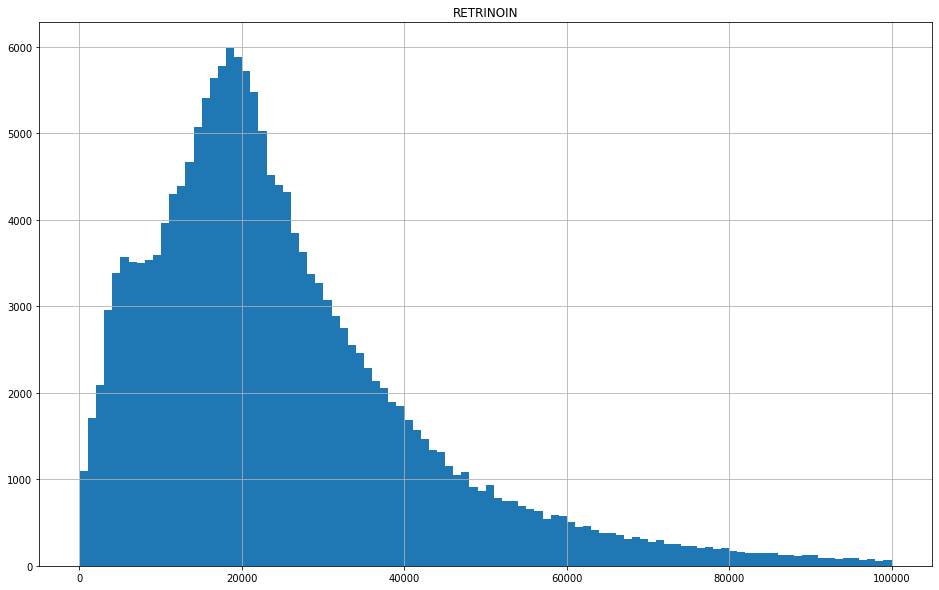

In [11]:
# We can see here the salary distribution for salaries below 100 thousand Euros
# per year. This is a right-skewed distribution, typical for salary distribution
df4_under100k = df2[df2['RETRINOIN'] < 100000]
df4_under100k.hist(column='RETRINOIN', bins=100,figsize=(16,10), )

In [12]:
# We can also see that the average salary for a female is below that of a male
avg_male = df5[df5['SEXO'] == 1]['Salary'].mean()
avg_female = df5[df5['SEXO'] == 6]['Salary'].mean()
print(f"The average salary for males is {avg_male}€ while for females only {avg_female}€")

The average salary for males is 30232.12981703658€ while for females only 22810.215291256078€


Text(0, 0.5, 'Average salary (€)')

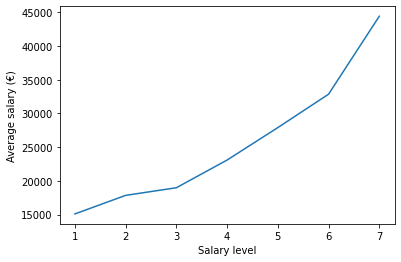

In [13]:
# We can also see the impact of having higher education in the average salary
salary_by_education = df5.groupby("ESTU")["Salary"].mean()
plt.plot(salary_by_education)
plt.xlabel("Salary level")
plt.ylabel("Average salary (€)")

## Sampling and binarizing the dataset
We currently have more than 177 thousand examples, which is great, but it slows down the learning process of the different Machine Learning algorithms we are going to run. For the purpose of demonstration, we are randomly picking 5 thousand samples.

We are going to predict the probability of a salary being above a threshold, given the rest of input parameters. The threshold we are setting is arbitrary and moving it will certainly impact that accuracy achieved. We decide to set the threshold at the median value for the sampled dataset. This makes sure the dataset is balanced. We will make the convention to call every salary above the median a "Good salary"



In [44]:
# Random sampling of 5000 examples without replacing to avoid duplicates, with
# random seed of 42 (because that is the answer to everything) and selecting
# axis = 0 which relates to rows (instead of columns)
df6 = df5.sample(n=5000, replace=False,random_state=42,axis=0)

# We check that the basic statistics have not changed with relation to the salary
df6.Salary.describe()

count    5.000000e+03
mean     2.752858e+04
std      4.132560e+04
min      1.977700e+02
25%      1.346632e+04
50%      2.163862e+04
75%      3.330629e+04
max      1.652368e+06
Name: Salary, dtype: float64

In [45]:
# We binarize now the dataset setting the threshold at the median (21638€)
median = df6.Salary.median()
salary_col = df6.Salary > median

df6.insert(loc=0,column="Good_salary",value= salary_col)

print(f"The theshold will is set at {median}€")
print(f"{salary_col.sum()} examples have a salary above the threshold, which is exactly half of 5000 -> balanced!")
df6

The theshold will is set at 21638.615€
2500 examples have a salary above the threshold, which is exactly half of 5000 -> balanced!


,Salary,CONTROL,MERCADO,SEXO,TIPOPAIS,RESPONSA,ESTU,ANOANTI,TIPOJOR,TIPOCON,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Economic_code_B0,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2.752858e+04,1.845600,1.968400,3.072000,1.057800,0.162600,4.372800,9.983800,1.174000,1.218800,0.11280,0.140400,0.159400,0.128200,0.278200,0.138600,0.04240,0.008400,0.046000,0.018000,0.008400,0.043600,0.012000,0.022600,0.023600,0.052000,0.008400,0.026600,0.062200,0.032800,0.044000,0.021600,0.024200,0.037600,0.058400,0.044800,0.008000,0.082000,0.094200,0.04100,0.040600,0.07980,0.037800,0.021400,0.11280,0.140400,0.159400,0.128200,0.278200,0.138600,0.04240,0.11280,0.140400,0.159400,0.128200,0.278200,0.138600,0.04240
std,4.132560e+04,0.361368,0.998199,2.463337,0.233388,0.369037,1.779566,10.037255,0.379147,0.413474,0.31638,0.347436,0.366085,0.334346,0.448157,0.345563,0.20152,0.091275,0.209506,0.132964,0.091275,0.204224,0.108896,0.148639,0.151815,0.222049,0.091275,0.160927,0.241543,0.178131,0.205116,0.145388,0.153685,0.190246,0.234522,0.206885,0.089093,0.274392,0.292136,0.19831,0.197381,0.27101,0.190731,0.144728,0.31638,0.347436,0.366085,0.334346,0.448157,0.345563,0.20152,0.31638,0.347436,0.366085,0.334346,0.448157,0.345563,0.20152
min,1.977700e+02,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.346632e+04,2.000000,1.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2.163862e+04,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,8.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000

In [48]:
#We now delete the Salary column and check the final shape and data types of the dataset
del df6["Salary"]
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 209735 to 107387
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Good_salary       5000 non-null   bool 
 1   CONTROL           5000 non-null   int64
 2   MERCADO           5000 non-null   int64
 3   SEXO              5000 non-null   int64
 4   TIPOPAIS          5000 non-null   int64
 5   RESPONSA          5000 non-null   int64
 6   ESTU              5000 non-null   int64
 7   ANOANTI           5000 non-null   int64
 8   TIPOJOR           5000 non-null   int64
 9   TIPOCON           5000 non-null   int64
 10  Region_1          5000 non-null   uint8
 11  Region_2          5000 non-null   uint8
 12  Region_3          5000 non-null   uint8
 13  Region_4          5000 non-null   uint8
 14  Region_5          5000 non-null   uint8
 15  Region_6          5000 non-null   uint8
 16  Region_7          5000 non-null   uint8
 17  Economic_code_B0  5000 non

# Training Machine Learning models with fixed Hyperparameters
In order to get a feeling about the accuracy (or any other metric like F1 score) we can achieve with Machine Learning models, we are going to run several of them with most parameters set by default. Afterwards, we will improve this by doing Hyperparameter Optimization (HPO).

First of all, we start by splitting the dataset in train (80%) and test (20%) sub-sets.

## Perceptron

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
rs = 42  # "Random" seed, which is the answer to every question

X = df6.drop("Good_salary", axis=1)
y = df6["Good_salary"]

# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)

from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), Perceptron(random_state = rs))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred, digits = 5))

              precision    recall  f1-score   support

       False    0.77246   0.77400   0.77323       500
        True    0.77355   0.77200   0.77277       500

    accuracy                        0.77300      1000
   macro avg    0.77300   0.77300   0.77300      1000
weighted avg    0.77300   0.77300   0.77300      1000



AUC 0.8664540000000001


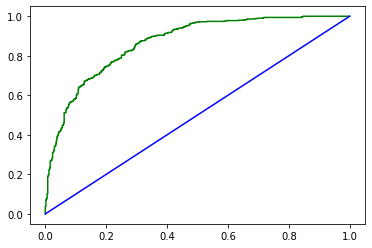

In [59]:
from sklearn.metrics import roc_curve, auc

y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = "green")
plt.plot([0, 1], [0, 1], color="blue")
print("AUC", auc(fpr,tpr))

## Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(StandardScaler(),LogisticRegression(random_state = rs))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred, digits = 5))

              precision    recall  f1-score   support

       False    0.81875   0.78600   0.80204       500
        True    0.79423   0.82600   0.80980       500

    accuracy                        0.80600      1000
   macro avg    0.80649   0.80600   0.80592      1000
weighted avg    0.80649   0.80600   0.80592      1000



AUC 0.9008300000000001


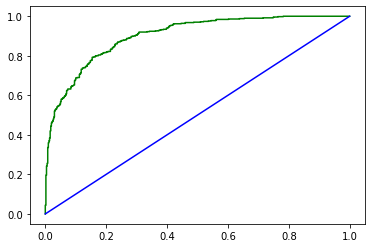

In [63]:
y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = "green")
plt.plot([0, 1], [0, 1], color="blue")
print("AUC", auc(fpr,tpr))

## Support Vector Machine with linear kernel

In [64]:
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(),SVC(kernel = "linear", random_state = rs))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred, digits = 5))

              precision    recall  f1-score   support

       False    0.81314   0.79200   0.80243       500
        True    0.79727   0.81800   0.80750       500

    accuracy                        0.80500      1000
   macro avg    0.80521   0.80500   0.80497      1000
weighted avg    0.80521   0.80500   0.80497      1000



AUC 0.900418


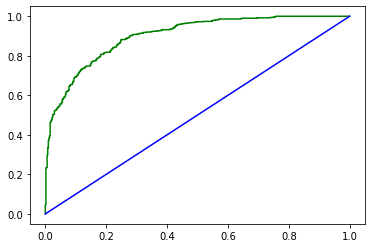

In [65]:
y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = "green")
plt.plot([0, 1], [0, 1], color="blue")
print("AUC", auc(fpr,tpr))

## Support Vector Machine with polynomial kernel



In [66]:
clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree = 2, random_state = rs))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred, digits = 5))

              precision    recall  f1-score   support

       False    0.77101   0.73400   0.75205       500
        True    0.74618   0.78200   0.76367       500

    accuracy                        0.75800      1000
   macro avg    0.75860   0.75800   0.75786      1000
weighted avg    0.75860   0.75800   0.75786      1000



AUC 0.837238


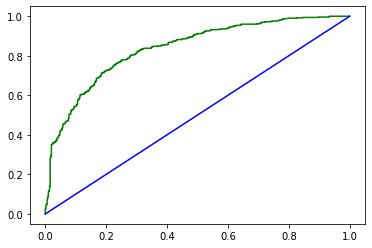

In [67]:
y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = "green")
plt.plot([0, 1], [0, 1], color="blue")
print("AUC", auc(fpr,tpr))

## Support Vector Machine with Radial Basis Function kernel


In [68]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", random_state = rs))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred, digits = 5))

              precision    recall  f1-score   support

       False    0.80943   0.79000   0.79960       500
        True    0.79492   0.81400   0.80435       500

    accuracy                        0.80200      1000
   macro avg    0.80217   0.80200   0.80197      1000
weighted avg    0.80217   0.80200   0.80197      1000



AUC 0.89155


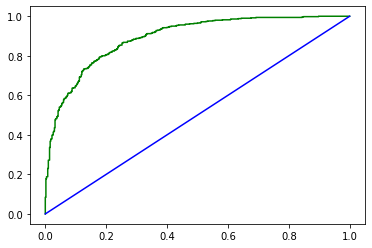

In [69]:
y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = "green")
plt.plot([0, 1], [0, 1], color="blue")
print("AUC", auc(fpr,tpr))

# Automated Hyperparameter Search
In order to find a model which is able to predict with high accuracy the "good salary", we are going to try several algorithms combined with several hyperparameters. In order to automate the search of hyperparameters, we are using "grid search with cross-validation" from SKLearn, which implements an exhaustive search through the given hyperparameters including cross-validation (5-fold).

We are saving the best models, so that later we can combine them to reach even better results

## K-Nearest Neighbors
In the first algorithm we are trying, we are going to seach for the best hyperparameters, being these: number of neighbors (k from 5 to 105 in steps of 10), weight function used in prediction (uniform or distance) and power parameter for the Minkowski metric (p being 1 for Manhattan distance and 2 for Euclidean distance)

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import pandas as pd

clf = Pipeline([("scaler",StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid = [{'knn__n_neighbors': range(5,106,10),
              'knn__weights': ['uniform','distance'],
              'knn__p' : [1,2]}]


grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='f1_weighted',
                           return_train_score=True,
                           verbose = 2)
grid_search.fit(X_train, y_train)
print(pd.DataFrame(grid_search.cv_results_))
print("Best estimator: ", grid_search.best_estimator_)
print("CV best result: ", grid_search.best_score_)
y_pred = grid_search.best_estimator_.predict(X_test)
print("F1 score for best estimator: ", f1_score(y_test,y_pred, average = "weighted"))

best_classifiers = []
threshold = 0.7

if(grid_search.best_score_>=threshold):
    best_classifiers.append(("knn",grid_search.best_estimator_))

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=5, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=5, knn__p=2, knn__we

## Suport Vector Machine
In this case, we are going to iterate through all possible kernels (linear, rbf, sigmoid and poly) and search the best regularization parameters (from 0 to 1 with logaritmic steps) and polynomial degree (2, 3 or 4)

In [98]:
clf = Pipeline([("scaler",StandardScaler()),("svc",SVC(random_state = rs, probability = True))])

param_grid = [{'svc__C': [0.0001,0.001,0.01,0.1,1],
              'svc__kernel': ['linear', 'rbf', 'sigmoid']},
              
              {'svc__C': [0.0001,0.001,0.01,0.1,1],
              'svc__kernel': ['poly'],
              'svc__degree': [2,3,4]}
  ]


grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='f1_weighted',
                           return_train_score=True,
                           verbose = 2,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)

print("Best estimator: ", grid_search.best_estimator_)
print("CV best result: ", grid_search.best_score_)
y_pred = grid_search.best_estimator_.predict(X_test)
print("F1 score for best estimator: ", f1_score(y_test,y_pred, average = "weighted"))

if(grid_search.best_score_>=threshold):
    best_classifiers.append(("svm",grid_search.best_estimator_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=1, kernel='linear', probability=True, random_state=42))])
CV best result:  0.8119729122522304
F1 score for best estimator:  0.8049670394296635


## Multi-Layer Perceptron (MLP)
Finally, we are searching for the best model with Neural Networks. The Hyperparameters are alpha (L2 regularization between 10e-5 and 10e-3), constant learning rate value (between 10e-4 and 10e-2) and number of epochs (max_iter to choose between 5, 10 and 50).

In [99]:
from sklearn.neural_network import MLPClassifier

clf = Pipeline([("scaler",StandardScaler()),("mlp",MLPClassifier(random_state = rs))])

param_grid = [{'mlp__alpha' : [0.00001, 0.0001, 0.001],
               'mlp__learning_rate_init' : [0.0001,0.001,0.01],
               'mlp__max_iter' : [5,10,50]}]


grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='f1_weighted',
                           return_train_score=True,
                           verbose = 2,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
print("Best estimator: ", grid_search.best_estimator_)
print("CV best result: ", grid_search.best_score_)
y_pred = grid_search.best_estimator_.predict(X_test)
print("F1 score for best estimator: ", f1_score(y_test,y_pred, average = "weighted"))

if(grid_search.best_score_>=threshold):
    best_classifiers.append(("mlp",grid_search.best_estimator_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=0.001, max_iter=10, random_state=42))])
CV best result:  0.8087178484803779
F1 score for best estimator:  0.8149465195441481


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Ensemble Learning
Now we are going to combine the best models found so far using voting, both hard and soft (weighted) voting. Finally, we will use "stacking"

In [100]:
# We check the models we currently have
best_classifiers

[('knn', Pipeline(steps=[('scaler', StandardScaler()),
                  ('knn', KNeighborsClassifier(n_neighbors=85, p=1))])),
 ('svm', Pipeline(steps=[('scaler', StandardScaler()),
                  ('svc',
                   SVC(C=1, kernel='linear', probability=True, random_state=42))])),
 ('mlp', Pipeline(steps=[('scaler', StandardScaler()),
                  ('mlp',
                   MLPClassifier(alpha=0.001, max_iter=10, random_state=42))]))]

In [102]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
clf = VotingClassifier(estimators=best_classifiers)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')
print("F1 Score (5-fold CV Mean):", cv_scores.mean())
print()
print("Metrics for test dataset with hard voting: ")
print()
print(classification_report(y_test,y_pred, digits = 5))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

F1 Score (5-fold CV Mean): 0.8112289574656841

F1 Score for test dataset with hard voting: 

              precision    recall  f1-score   support

       False    0.81429   0.79800   0.80606       500
        True    0.80196   0.81800   0.80990       500

    accuracy                        0.80800      1000
   macro avg    0.80812   0.80800   0.80798      1000
weighted avg    0.80812   0.80800   0.80798      1000



In [103]:
clf = VotingClassifier(estimators=best_classifiers, voting = "soft")
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')

print("F1 Score (5-fold CV Mean):", cv_scores.mean())
print()
print("Metrics for test dataset using soft voting")
print()
print(classification_report(y_test,y_pred, digits = 5))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

F1 Score (5-fold CV Mean): 0.8114605944799097

F1 Score for test dataset using soft voting

              precision    recall  f1-score   support

       False    0.81520   0.79400   0.80446       500
        True    0.79922   0.82000   0.80948       500

    accuracy                        0.80700      1000
   macro avg    0.80721   0.80700   0.80697      1000
weighted avg    0.80721   0.80700   0.80697      1000



In [105]:
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(estimators=best_classifiers)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')
print("F1 Score (5-fold CV Mean):", cv_scores.mean())
print()
print("Metrics for test dataset with stacking: ")
print()
print(classification_report(y_test,y_pred, digits = 5))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

F1 Score (5-fold CV Mean): 0.8112163580446081

Metrics for test dataset with stacking: 

              precision    recall  f1-score   support

       False    0.81497   0.78400   0.79918       500
        True    0.79191   0.82200   0.80667       500

    accuracy                        0.80300      1000
   macro avg    0.80344   0.80300   0.80293      1000
weighted avg    0.80344   0.80300   0.80293      1000



# Deep Learning
Although we have already used Deep Neural Networks with SKLearn (Multi-Layer Perceptron), now are are going to us a library which is optimized for this purpose, called TensorFlow and using the Keras API.



In [106]:
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
rs = 42  # "Random" seed

random.seed(rs)
np.random.seed(rs)
tf.random.set_seed(rs)

# The input has 57 features
input_shape = [57]

In [110]:
# We start with a simple fully connected network with 2 hidden layers with 100 nodes each
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", input_shape = input_shape))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               5800      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 16,001
Trainable params: 16,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.5700 - accuracy: 0.7210 - val_loss: 0.4836 - val_accuracy: 0.7763
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.7931 - val_loss: 0.4552 - val_accuracy: 0.7825
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.7998 - val_loss: 0.4489 - val_accuracy: 0.7962
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.8219 - val_loss: 0.4426 - val_accuracy: 0.7887
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.8163 - val_loss: 0.4370 - val_accuracy: 0.8037
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3725 - accuracy: 0.8329 - val_loss: 0.4355 - val_accuracy: 0.8000
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8324 - val_loss: 0.4326 - val_accuracy: 0.7975

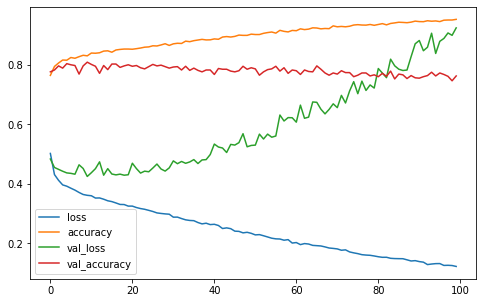

In [111]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose = 1)
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [112]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.8946 - accuracy: 0.7980


[0.8946298360824585, 0.7979999780654907]

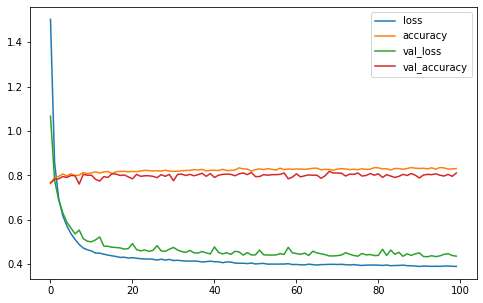

In [115]:
# As we could see, the accuracy on the train dataset increases always, but this is not the case on the test dataset. This is an indication of over-fitting.
# To reduce overfitting, we are going to use regularization
from keras import regularizers

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape = input_shape))
model.add(keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [116]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.4056 - accuracy: 0.8150


[0.4056442081928253, 0.8149999976158142]

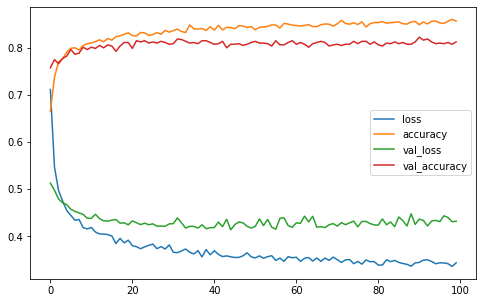

In [117]:
# Although we have seen an improvement, we see the learning is stuck at ~81%
# We try now with Dropout
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", input_shape = input_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [118]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8240


[0.4058005213737488, 0.8240000009536743]

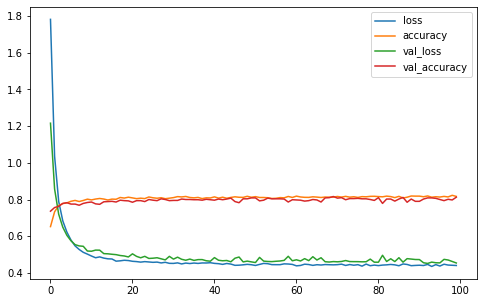

In [125]:
# Since both regularization methods seemed to work to combat the overfitting, we are going to combine them reducing the strength of each of them
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape = input_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [126]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8240


[0.42386528849601746, 0.8240000009536743]

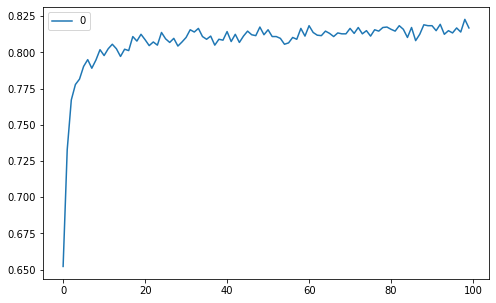

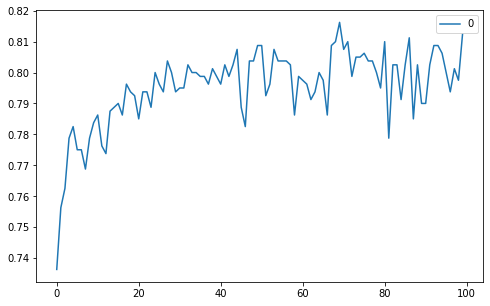

In [134]:
# This looks good, we see that both accuracies seem to keep increasing

pd.DataFrame(history.history['accuracy']).plot(figsize=(8, 5))
pd.DataFrame(history.history['val_accuracy']).plot(figsize=(8, 5))

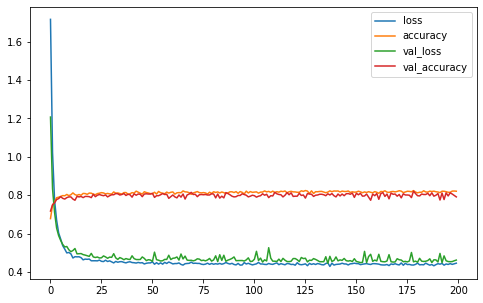

In [135]:
# Therefore we train for a little longer (200 epochs)
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape = input_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

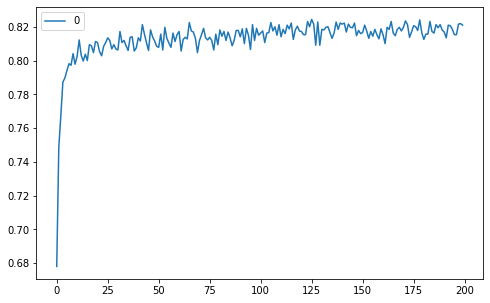

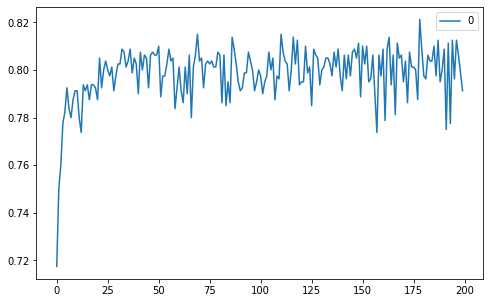

In [137]:
pd.DataFrame(history.history['accuracy']).plot(figsize=(8, 5))
pd.DataFrame(history.history['val_accuracy']).plot(figsize=(8, 5))

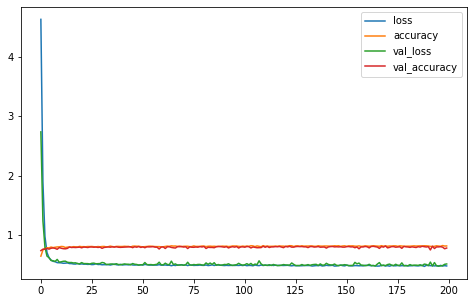

In [138]:
# It is not really improving anymore. We need to use a bigger network.
# We define now a network with 4 hidden layers, each with 200 nodes
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape = input_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [139]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.4746 - accuracy: 0.8090


[0.47463345527648926, 0.8090000152587891]

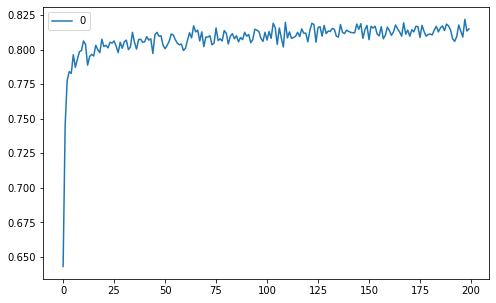

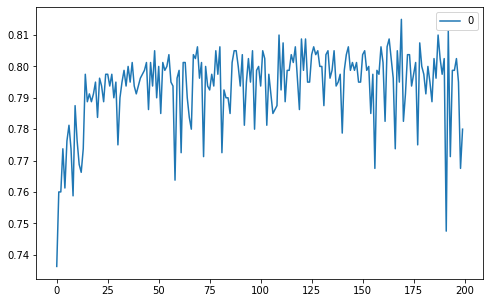

In [140]:
pd.DataFrame(history.history['accuracy']).plot(figsize=(8, 5))
pd.DataFrame(history.history['val_accuracy']).plot(figsize=(8, 5))

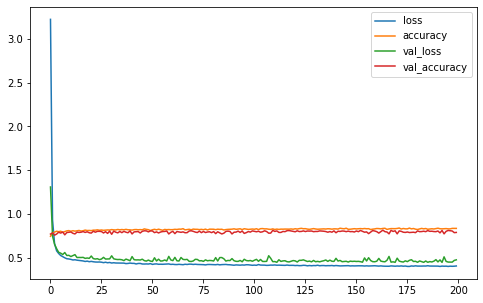

In [142]:
# This is also not improving anymore. Maybe too much regularization?
# We remove now the Dropouts
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape = input_shape))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [143]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.8160


[0.44286608695983887, 0.8159999847412109]

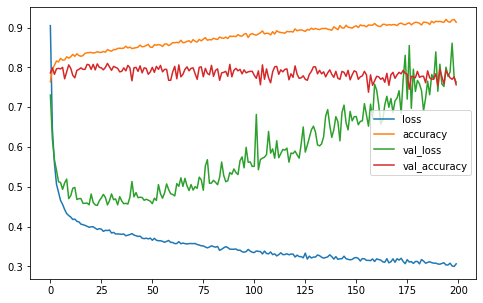

In [144]:
# This also didn't really improve, maybe still too much regularization?
# We reduce now the L2 factor
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.001), input_shape = input_shape))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [145]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.7765 - accuracy: 0.7760


[0.7765381932258606, 0.7760000228881836]

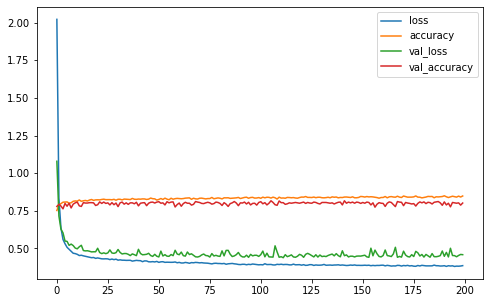

In [146]:
# WOW! That was too little regularization, but we have again hope! The network is able
# to learn the train dataset above 90%! We increase again the regularization to an intermediate value
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.005), input_shape = input_shape))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.005), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.005), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.005), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [147]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8170


[0.43117037415504456, 0.8169999718666077]

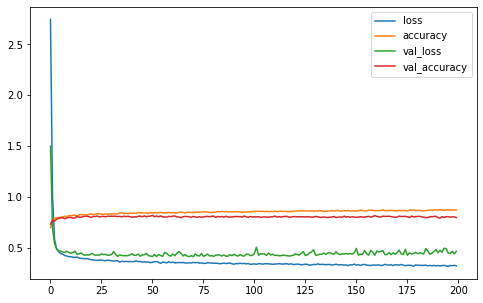

In [154]:

# We do now a combination of Dropout and L2 regularization
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", input_shape = input_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5));

In [155]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.8140


[0.46085020899772644, 0.8140000104904175]

# Final training with complete dataset
As we have spent some time trying to improve the accuracy of our model and we are not able to get it any better, we decied to use the complete dataset with over 170k examples, instead of the 5k samples we took for simplification. This is going to take a lot longer in training, but this could bring us a push in fitting the model

In [157]:
# We binarize the original dataset setting the threshold at the median
median = df5.Salary.median()
salary_col = df5.Salary > median

df5.insert(loc=0,column="Good_salary",value= salary_col)

print(f"The theshold will is set at {median}€")
print(f"{salary_col.sum()} examples have a salary above the threshold, which is exactly half of 5000 -> balanced!")
df5


The theshold will is set at 21608.01€
88865 examples have a salary above the threshold, which is exactly half of 5000 -> balanced!


,Good_salary,Salary,CONTROL,MERCADO,SEXO,TIPOPAIS,RESPONSA,ESTU,ANOANTI,TIPOJOR,TIPOCON,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Economic_code_B0,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
0,False,6128.65,2,3,1,1,0,3,28,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,False,16509.97,2,3,1,1,0,3,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,False,18284.40,2,3,6,1,0,7,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,False,16549.97,2,3,1,1,0,3,14,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,False,16554.71,2,3,1,1,0,3,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216721,False,8264.71,1,2,6,1,0,3,16,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
216722,True,22480.28,1,2,6,1,0,3,24,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
216723,False,20957.13,1,2,6,1,0,3,21,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
216724,False,20216.56,1,2,6,1,0,2,21,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [159]:
del df5["Salary"]
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177731 entries, 0 to 216725
Data columns (total 58 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Good_salary       177731 non-null  bool 
 1   CONTROL           177731 non-null  int64
 2   MERCADO           177731 non-null  int64
 3   SEXO              177731 non-null  int64
 4   TIPOPAIS          177731 non-null  int64
 5   RESPONSA          177731 non-null  int64
 6   ESTU              177731 non-null  int64
 7   ANOANTI           177731 non-null  int64
 8   TIPOJOR           177731 non-null  int64
 9   TIPOCON           177731 non-null  int64
 10  Region_1          177731 non-null  uint8
 11  Region_2          177731 non-null  uint8
 12  Region_3          177731 non-null  uint8
 13  Region_4          177731 non-null  uint8
 14  Region_5          177731 non-null  uint8
 15  Region_6          177731 non-null  uint8
 16  Region_7          177731 non-null  uint8
 17  Economic_c

In [161]:
X = df5.drop("Good_salary", axis=1)
y = df5["Good_salary"]

# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)

Epoch 1/200
3555/3555 [==============================] - 11s 3ms/step - loss: 0.4213 - accuracy: 0.8026 - val_loss: 0.3767 - val_accuracy: 0.8245
Epoch 2/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3817 - accuracy: 0.8270 - val_loss: 0.3782 - val_accuracy: 0.8258
Epoch 3/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3784 - accuracy: 0.8301 - val_loss: 0.3686 - val_accuracy: 0.8297
Epoch 4/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3777 - accuracy: 0.8289 - val_loss: 0.3781 - val_accuracy: 0.8279
Epoch 5/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3782 - accuracy: 0.8314 - val_loss: 0.3996 - val_accuracy: 0.8278
Epoch 6/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3807 - accuracy: 0.8283 - val_loss: 0.3745 - val_accuracy: 0.8264
Epoch 7/200
3555/3555 [==============================] - 10s 3ms/step - loss: 0.3772 - accuracy: 0.8319 - val_loss: 0.3765 -

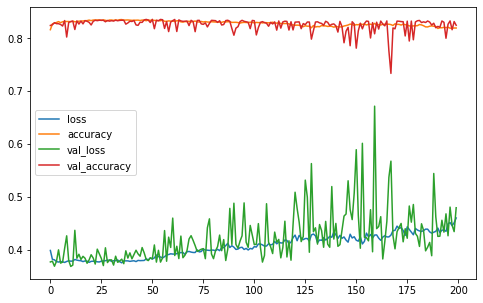

In [166]:
# We start first without any regularization to see if it overfits

model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation="relu", input_shape = input_shape))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(200, activation="relu"))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 1)

pd.DataFrame(history.history).plot(figsize=(8, 5))

In [167]:
model.evaluate(X_test,y_test)

1111/1111 [==============================] - 1s 1ms/step - loss: 0.4837 - accuracy: 0.8241


[0.48372262716293335, 0.8240638971328735]

Epoch 1/200
3555/3555 [==============================] - 49s 13ms/step - loss: 0.4307 - accuracy: 0.8005 - val_loss: 0.3746 - val_accuracy: 0.8271
Epoch 2/200
3555/3555 [==============================] - 47s 13ms/step - loss: 0.3796 - accuracy: 0.8266 - val_loss: 0.3820 - val_accuracy: 0.8279
Epoch 3/200
3555/3555 [==============================] - 46s 13ms/step - loss: 0.3757 - accuracy: 0.8304 - val_loss: 0.3688 - val_accuracy: 0.8293
Epoch 4/200
3555/3555 [==============================] - 47s 13ms/step - loss: 0.3788 - accuracy: 0.8281 - val_loss: 0.3759 - val_accuracy: 0.8310
Epoch 5/200
3555/3555 [==============================] - 46s 13ms/step - loss: 0.3798 - accuracy: 0.8310 - val_loss: 0.3755 - val_accuracy: 0.8309
Epoch 6/200
3555/3555 [==============================] - 47s 13ms/step - loss: 0.3852 - accuracy: 0.8283 - val_loss: 0.3806 - val_accuracy: 0.8261
Epoch 7/200
3555/3555 [==============================] - 47s 13ms/step - loss: 0.3823 - accuracy: 0.8307 - val_loss: 0

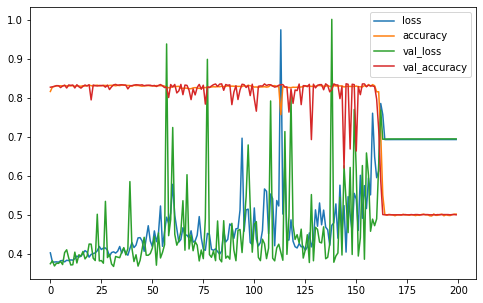

In [168]:
# It looks like the network needs more complexity to be able to improve accuracy
# We define 2 additional layers and duplicate the number of nodes in each layer
# We go for a walk until this is done :)

model = keras.models.Sequential()
model.add(keras.layers.Dense(400, activation="relu", input_shape = input_shape))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(400, activation="relu"))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(400, activation="relu"))
model.add(keras.layers.Dense(400, activation="relu"))
model.add(keras.layers.Dense(400, activation="relu"))
model.add(keras.layers.Dense(400, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 1)

pd.DataFrame(history.history).plot(figsize=(8, 5))

In [169]:
model.evaluate(X_test,y_test)

1111/1111 [==============================] - 3s 3ms/step - loss: 0.6928 - accuracy: 0.5006


[0.6927550435066223, 0.5006048083305359]

# Quantum Machine Learning
In the last steps of this notebook, we are going to use the library Pennylane to simulate Quantum Computing.

In [171]:
!pip install pennylane==0.14.1
import pennylane as qml
import os
os.environ['PYTHONHASHSEED']='0'

In [192]:
# We are using again the sampled dataset with 5000 examples for simplicity
X = df6.drop("Good_salary", axis=1)
y = df6["Good_salary"]

# We take only 2 features: Studies and years of experience
X = pd.concat([X.ESTU,X.ANOANTI], axis=1)

# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)

# Now we scale from 0 to pi, as we are using angle embedding
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [193]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    state_0 = [[1], [0]]
    y = state_0 * np.conj(state_0).T
    return [qml.expval(qml.Hermitian(y, wires=[0]))]

In [194]:
# We are trying with only one repetition in the variational form
n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# The Keras model has as only layer the previously defined quantum circuit
model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05) # This is a high value to accelerate learning
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [196]:
# We train with 10 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/10
100/100 [==============================] - 63s 629ms/step - loss: 1.8210 - accuracy: 0.3256 - val_loss: 1.7008 - val_accuracy: 0.3487
Epoch 2/10
100/100 [==============================] - 62s 625ms/step - loss: 1.8205 - accuracy: 0.3256 - val_loss: 1.6966 - val_accuracy: 0.3487
Epoch 3/10
100/100 [==============================] - 62s 622ms/step - loss: 1.8196 - accuracy: 0.3256 - val_loss: 1.6952 - val_accuracy: 0.3487
Epoch 4/10
100/100 [==============================] - 62s 622ms/step - loss: 1.8200 - accuracy: 0.3256 - val_loss: 1.7115 - val_accuracy: 0.3487
Epoch 5/10
100/100 [==============================] - 62s 622ms/step - loss: 1.8221 - accuracy: 0.3256 - val_loss: 1.6945 - val_accuracy: 0.3487
Epoch 6/10
100/100 [==============================] - 61s 609ms/step - loss: 1.8242 - accuracy: 0.3256 - val_loss: 1.7343 - val_accuracy: 0.3487
Epoch 7/10
100/100 [==============================] - 61s 613ms/step - loss: 1.8275 - accuracy: 0.3256 - val_loss: 1.6959 - val_ac

32/32 [==============================] - 11s 332ms/step - loss: 1.7945 - accuracy: 0.3350


[1.7944812774658203, 0.33500000834465027]

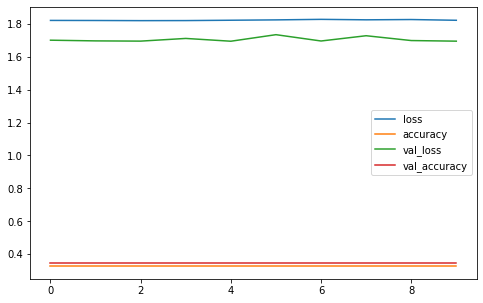

In [197]:
pd.DataFrame(history.history).plot(figsize=(8, 5));
model.evaluate(X_test, y_test)

# Conclusions
We have selected a recent public Dataset from the Spanish National Statistics Institute (INE) which has not yet been frequently analysed or studied. The survey is very extense both by number of participants (near to 216 thousand) and by number of features (56 columns). For this reason, one of the first and biggest efforts was related to understanding the data and doing the right feature engineering to be able to work with this dataset.

We have shown several interesting visualizations of the data, which gave us an idea of the distribution of the salaries (gaussian distribution, skewed right) and some of the factors which impact positively the salary (education and being male). We have filtered our dataset to consider only salaries which origin is not in any way related to disabilities. This has been done to avoid any possible bias coming from this particularity.

Although we wanted to reduce the high number of features, we ended with a similar number after dropping 41 columns and doing re-encoding (one-hot). In any case, most of the unnecessary data was eliminated. In order to reduce the wait time for training the Machine Learning models, we have randomly sampled the dataset, selecting 5 thousand from the 177 thousand remaining examples.

With this reduced dataset, we started training ML models with fixed hyperparameters, achieving the next accuracies:
- Perceptron: 77.3%
- Logistic regression: 80.6%
- SVM linear kernel: 80.5% 
- SVM polynomial kernel: 75.8%
- SVM RBF kernel: 80.2%

As we can see, in this case the Logistic Regression was the best predictor. From the different kernels used in SVM, "linear kernel" gave the best result.

When we tuned the hyperparemeters using Grid Search with Cross-Validation, we achieved the next best models with their related hyperparemeters (F1-scores in parentheses):
- KNN: 85 neighbors, p (power parameter for them Minskowski metric) = 1 (Manhattan distance) (0.76)
- SVM: linear kernel, C regularization strength = 1  (0.8049)
- MLP: alpha = 0.001, max_iter = 10 (0.8149)

From the used algorithms, MLP showed the best performance of all. SVM reached again the best result with the linear kernel.

When we used Ensemble Learning with the best performing models, we got the next accuracies (F1-scores in parentheses)
- Hard voting: 80.8% (0.8099)
- Soft voting: 80.7% (0.8095)
- Stacking: 80.3% (0.8067)

As we can see, the scores are between the best and the worst performing model individually, without using Ensemble.

After these experiments, we used the Keras API for training Deep Learning models. The initial trials (100 nodes in each layer, 2 hidden layers) showed overfitting behavior and they were therefore not able to reach the performance of other classical ML algorithms like Logistic Regression. In this case, we observed 79.8% accuracy in the test dataset.

In order to reduce overfitting, we used regularization (dropout and L2 regularization with different combinations). In this case, we saw a performance increase and reached an accuracy between 81.5 and 82.4%. This was so far the best result seen.

In the search for improving even more, we trained longer (200 epochs instead of 100), but this did not improve accuracy. Learning stagnates or even starts to overfit again reducing accuracy on the test dataset to around 80%. Doubling number of nodes and layers did not improve accuracy in any case either.

As a final experiments with Deep Learning, we re-loaded the complete dataset (~177k examples). In this case, we observed a much longer training time (over 10x), and the best accuracy matching the best previous case with 82.4% in the test Dataset. We tried to improve the capacity of the Network to learn complex patterns by doubling the number of nodes and adding 2 additional hidden layers. This resulted in ~5x training time (almost 3 hours) and no improvements in accuracy observed. After 163 epochs, the accuracy of the training and validation sets collapsed from ~83% to 50% (same performance as random selection). Early stopping would have been beneficial in this case.

Quantum Machine Learning was explored at the end. We used 2 qubits and therefore only 2 input features (Studies and Years of experience). Unfortunately, the accuracy achieved was below random selection, which is a very disappointing result.